### **本节介绍单发多框目标检测**

**模型大致如下**

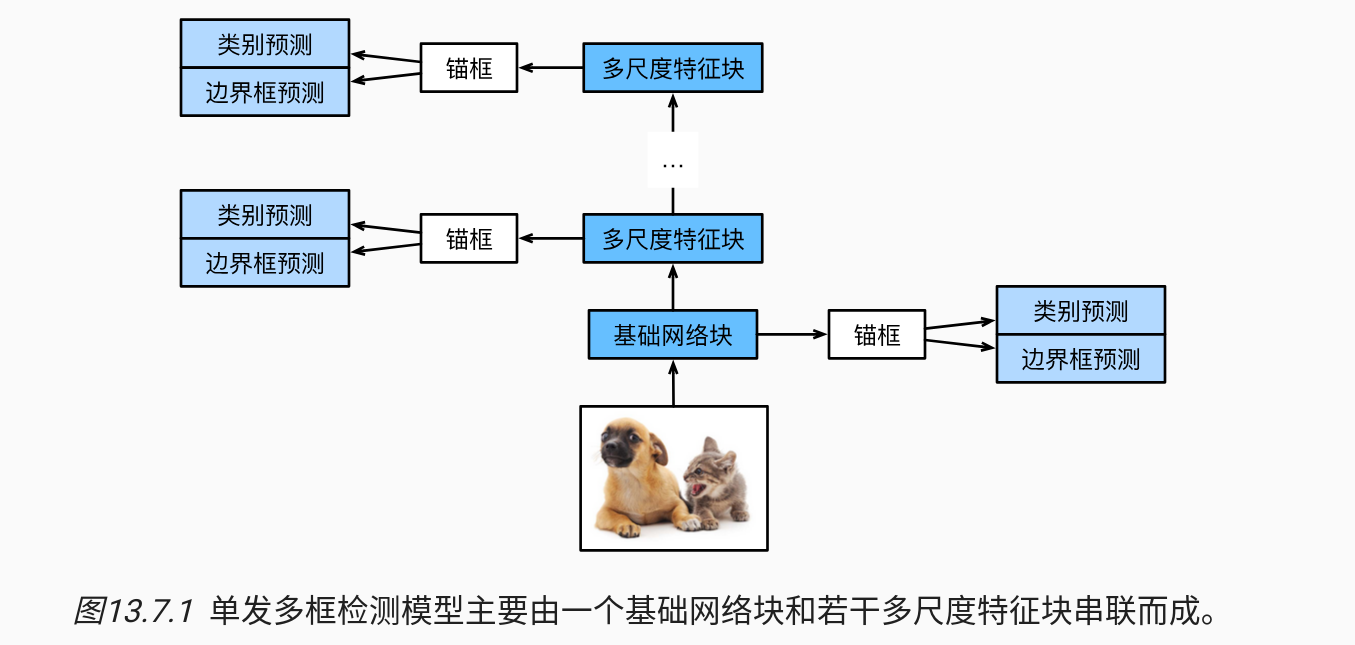

**一、下面进行模型分解实现**

In [1]:
import torch
import numpy as np
from torch import nn
from d2l import torch as d2l
import time
import matplotlib.pyplot as plt
import torchvision
from torch.nn import functional as F

**(1)类别预测层**

In [2]:
# 通过卷积后的图像通道来预测，减少参数量
def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)

**(2)边界框预测层**

In [3]:
# 预测边界框
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1) # 4为框的定位坐标(x1,y1,x2,y2)

In [4]:
# 块的前向传播
def forward(x, block):
    return block(x)

# 测试类别预测层
Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
print(Y1.shape, Y2.shape)

torch.Size([2, 55, 20, 20]) torch.Size([2, 33, 10, 10])


正如我们所看到的，除了批量大小这一维度外，其他三个维度都具有不同的尺寸。
为了将这两个预测输出链接起来以提高计算效率，我们将把这些张量转换为更一致的格式。

通道维包含中心相同的锚框的预测结果。我们首先将通道维移到最后一维。
因为不同尺度下批量大小仍保持不变，我们可以将预测结果转成二维的（批量大小，高$\times$宽$\times$通道数）的格式，以方便之后在维度$1$上的连结。


In [5]:
# transpose并展开成(批大小，其他)
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1) # torch.permute类似numpy.transpose

# 将展开后的不同预测层连接
def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

In [6]:
# 测试2
x = torch.rand(1,3)
y = torch.rand(1,3)
cat = torch.cat([x,y],dim = 0)
print(cat.shape)

torch.Size([2, 3])


**(3)高宽减半层(感受野扩大层)**

In [7]:
# 高宽减半层，有块架构可知，感受野扩大6倍，1x1 -> 6x6
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

**(4)基本网络块**

基本网络块用于从输入图像中抽取特征。
为了计算简洁，我们构造了一个小的基础网络，该网络串联3个高和宽减半块，并逐步将通道数翻倍。
给定输入图像的形状为$256\times256$，此基本网络块输出的特征图形状为$32 \times 32$（$256/2^3=32$）。

In [8]:
def base_net():
    blk = [] # 基本网络块列表(由多个减半块组成)
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

**完整的模型**

[**完整的单发多框检测模型由五个模块组成**]。每个块生成的特征图既用于生成锚框，又用于预测这些锚框的类别和偏移量。在这五个模块中，第一个是基本网络块，第二个到第四个是高和宽减半块，最后一个模块使用全局最大池将高度和宽度都降到1。从技术上讲，第二到第五个区块都是 :numref:`fig_ssd`中的多尺度特征块。

In [9]:
# 获取模型中的块
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

**二、下面定义块的前向传播函数**

理解：每个块本身即可以作为输出层，也可以作为中间层

与图像分类任务不同，此处的输出包括：CNN特征图`Y`；在当前尺度下根据`Y`生成的锚框；预测的这些锚框的类别和偏移量（基于`Y`）。

In [10]:
def blk_forward(X,blk,size,ratio,cls_predictor, bbox_predictor):
    """块的前向传播
    输入
    X : 图像
    blk : 当前尺度下的块
    size,ratio : 生成锚框要用的参数
    cls_predictor,bbox_predictor : 类别预测层、预测框预测层

    输出
    (CNN特征图Y,当前尺度即Y下的锚框,类别预测,预测框)
    """
    Y = blk(X)
    anchors = d2l.multibox_prior(Y,sizes = size,ratios = ratio) # 当前特征图下生成锚框
    cls_preds = cls_predictor(Y) # 获取输出的预测类别的层
    bbox_preds = bbox_predictor(Y) # 获取预测锚框(即定位框)的层
    return (Y,anchors,cls_preds,bbox_preds)

In [11]:
# 定义块的大小及比例数据
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

**完整的模型类：TinySSD**

In [12]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            # 即赋值语句self.blk_i=get_blk(i)
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                    num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
                                                      num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # getattr(self,'blk_%d'%i)即访问self.blk_i
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1) # 将不同尺度上的锚框拼接
        cls_preds = concat_preds(cls_preds) # 将不同尺度上的预测类别拼接
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds) # 将不同尺度上的预测框进行拼接
        return anchors, cls_preds, bbox_preds

In [ ]:
# 测试
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape) # [1,5444,4]，批大小为1的原因是batch_size中的图片大小一样，一个图片生成的锚框就适用于其他的
print('output class preds:', cls_preds.shape) # 用通道来预测类别
print('output bbox preds:', bbox_preds.shape) # 预测框4个点，那么5444 * 4 = 21776

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


e:\My_environment\anaconda3\envs\d2l\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


**三、下面进行模型的训练**

In [70]:
# 读取香蕉数据集
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


In [72]:
# 网络初始化
device, net = d2l.try_gpu(), TinySSD(num_classes = 1)
trainer = torch.optim.SGD(net.parameters(), lr = 0.2, weight_decay = 5e-4)

目标检测有两种类型的损失。
第一种有关锚框类别的损失：我们可以简单地复用之前图像分类问题里一直使用的交叉熵损失函数来计算；
第二种有关正类锚框偏移量的损失：预测偏移量是一个回归问题。
但是，对于这个回归问题，我们在这里不使用 :numref:`subsec_normal_distribution_and_squared_loss`中描述的平方损失，而是使用$L_1$范数损失，即预测值和真实值之差的绝对值。
掩码变量`bbox_masks`令负类锚框和填充锚框不参与损失的计算。
最后，我们将锚框类别和偏移量的损失相加，以获得模型的最终损失函数。

In [73]:
# 定义损失函数
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

In [74]:
# 定义评估函数

# 类别预测评估函数
def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax需要指定最后一维。
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

# 检测框位置评估函数
def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

In [78]:
nums_epoch = 1
net = net.to(device)
use_times = 0
plt_loss = []
for epoch in range(nums_epoch):
    start = time.perf_counter() # 相比time.time()更加精确
    net.train() # 切换回训练模式
    loss_save = 0
    for features,target in train_iter:
        # 清空梯度
        trainer.zero_grad()

        # 切换硬件
        X = features.to(device)
        Y = target.to(device) # Target为实际目标的位置

        # 网络mini-batch输入的前向传播
        anchors,cls_preds,bbox_preds = net(X)

        # 为生成的锚框标注类别与偏移量
        bbox_labels,bbox_masks,cls_labels = d2l.multibox_target(anchors,Y) # bbox_labels为实际偏移量

        # 根据类别、偏移量的预测和标注值计算损失函数
        loss = calc_loss(cls_preds,cls_labels,bbox_preds,bbox_labels,bbox_masks)

        # 反向传播及更新权重参数
        loss.mean().backward()
        loss_save += loss.mean().item()
        trainer.step()
    plt_loss.append(loss_save / len(train_iter))
    end = time.perf_counter()
    print(f"epoch{epoch} use:{end - start} seconds")
    use_times += end - start

epoch0 use:41.34963909999988 seconds


In [86]:
for x,y in train_iter:
    print(y.shape)
    print(y)
    break

torch.Size([32, 1, 5])
tensor([[[0.0000, 0.3242, 0.6719, 0.5547, 0.9023]],

        [[0.0000, 0.3398, 0.0898, 0.5430, 0.2852]],

        [[0.0000, 0.4102, 0.1172, 0.6016, 0.2578]],

        [[0.0000, 0.2227, 0.3672, 0.4531, 0.5938]],

        [[0.0000, 0.6523, 0.7930, 0.8320, 0.9531]],

        [[0.0000, 0.0547, 0.1836, 0.2422, 0.4297]],

        [[0.0000, 0.4258, 0.2031, 0.6328, 0.3945]],

        [[0.0000, 0.2695, 0.7852, 0.4688, 0.9570]],

        [[0.0000, 0.5664, 0.0469, 0.7734, 0.2383]],

        [[0.0000, 0.3594, 0.0742, 0.5312, 0.2578]],

        [[0.0000, 0.6328, 0.3945, 0.8398, 0.6641]],

        [[0.0000, 0.5078, 0.6328, 0.6797, 0.8125]],

        [[0.0000, 0.2148, 0.5820, 0.4570, 0.7539]],

        [[0.0000, 0.2578, 0.6953, 0.4492, 0.8789]],

        [[0.0000, 0.2578, 0.6328, 0.4883, 0.8086]],

        [[0.0000, 0.2852, 0.1133, 0.5195, 0.3320]],

        [[0.0000, 0.7695, 0.7031, 0.9570, 0.9336]],

        [[0.0000, 0.2656, 0.6836, 0.4609, 0.8711]],

        [[0.0000, 0.355

Model train use 41.34963909999988 seconds


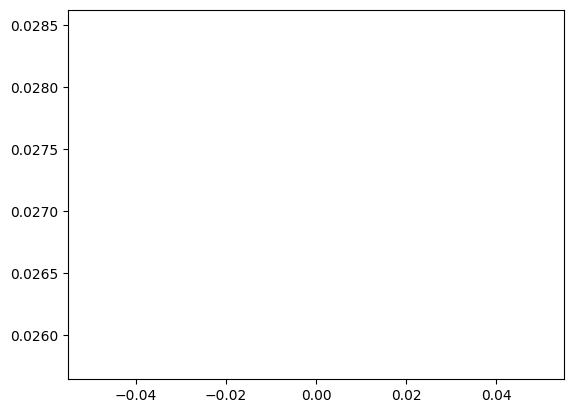

In [79]:
print(f"Model train use {use_times} seconds")
plt.plot(np.arange(0,len(plt_loss),1),plt_loss)
plt.show()

**四、下面进行模型的应用——目标检测**

In [82]:
# 读入待检测图片并化为可输入到网络的格式
X = torchvision.io.read_image('images/banana.jpg').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()

In [84]:
# 预测函数
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

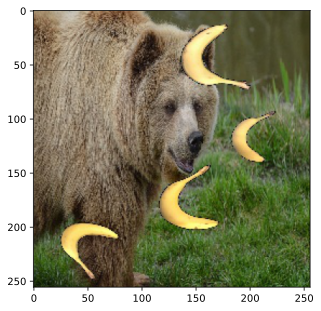

In [85]:
# 展示函数
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output.cpu(), threshold=0.9)
# 因为仅训练了一次，无法成功目标检测